# Application of the TadGAN method to signals from the NAB Dataset.

The notebook is based on the Tulog tutorial from the Orion-ML library on GitHub: https://github.com/sintel-dev/Orion/blob/master/tutorials/tulog/Tulog.ipynb.

Basic function was created by the Sintel MIT library. Source: https://github.com/sintel-dev/Orion/tree/master. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

In [2]:
from data import load_signal, load_anomalies

## Data Loading and Preparation

Load the signal for analysis. Load the associated anomaly ground truth from a separate .csv file.

Aggregate values over a specified time span. Then, impute missing values using a SimpleImputer. Finally, normalise values to an interval of [-1, 1] using MinMaxScaler.

In [3]:
signal = 'exchange-2_cpc_results'
df = load_signal(signal)
known_anomalies = load_anomalies(signal)
df.head(5)

,timestamp,value
0,1309471201,0.081965
1,1309474801,0.098972
2,1309478401,0.065314
3,1309482001,0.070663
4,1309485601,0.102490


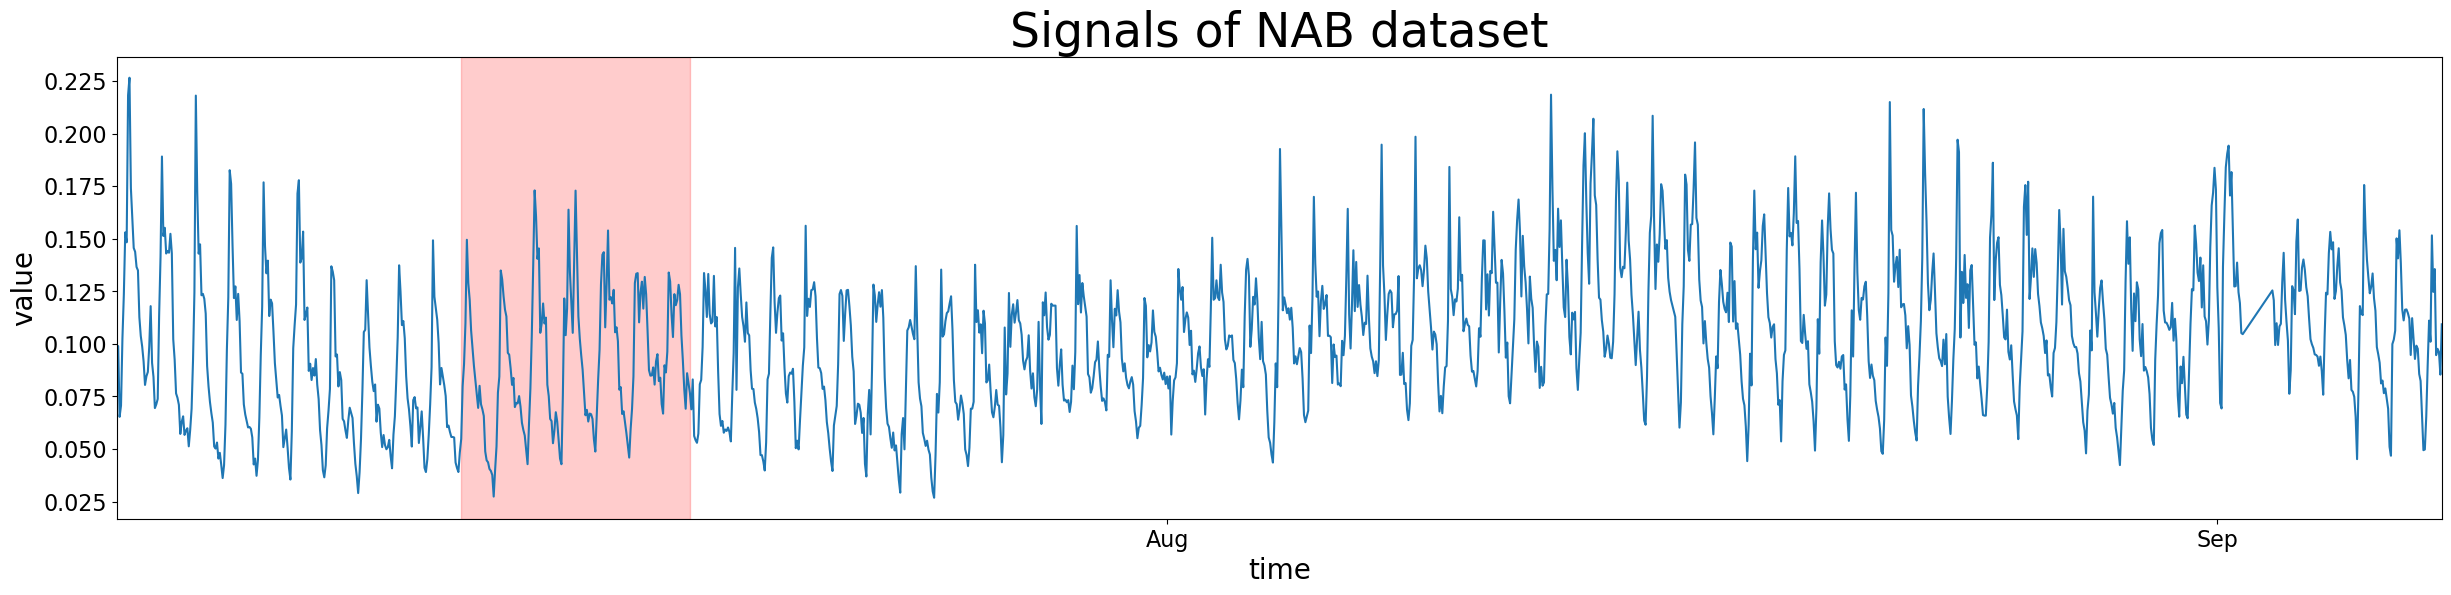

In [4]:
#plot signal and existing anomalies
plot(df, known_anomalies)

In [6]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """Aggregate values over given time span.
    Args:
        X (ndarray or pandas.DataFrame):
            N-dimensional sequence of values.
        interval (int):
            Integer denoting time span to compute aggregation of.
        time_column (int):
            Column of X that contains time values.
        method (str or list):
            Optional. String describing aggregation method or list of strings describing multiple
            aggregation methods. If not given, `mean` is used.
    Returns:
        ndarray, ndarray:
            * Sequence of aggregated values, one column for each aggregation method.
            * Sequence of index values (first index of each aggregated segment).
    """
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

X, index = time_segments_aggregate(df, interval=3600, time_column='timestamp')

In [7]:
#impute missing values
imp = SimpleImputer()
X = imp.fit_transform(X)

In [8]:
#normalise data
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

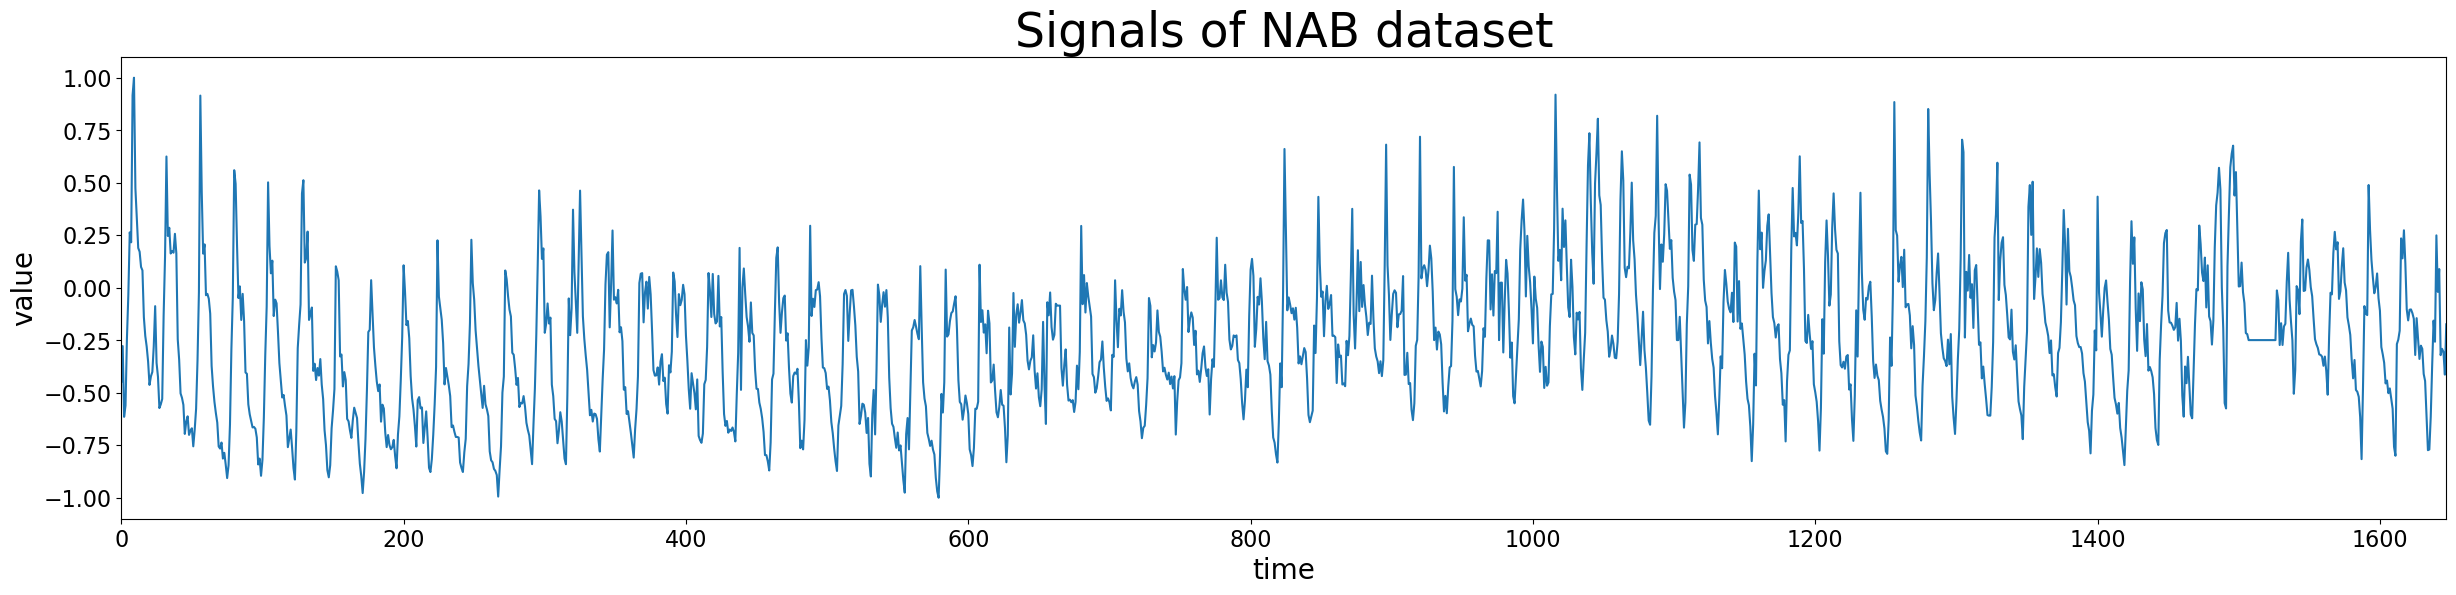

In [9]:
#plotting the processed signal
plot_ts(X)

Slice the data using the rolling window

In [10]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

In [11]:
#print information about training signal
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))

Training data input shape: (1548, 100, 1)
Training data index shape: (1548,)
Training y shape: (1548, 1)
Training y index shape: (1548,)


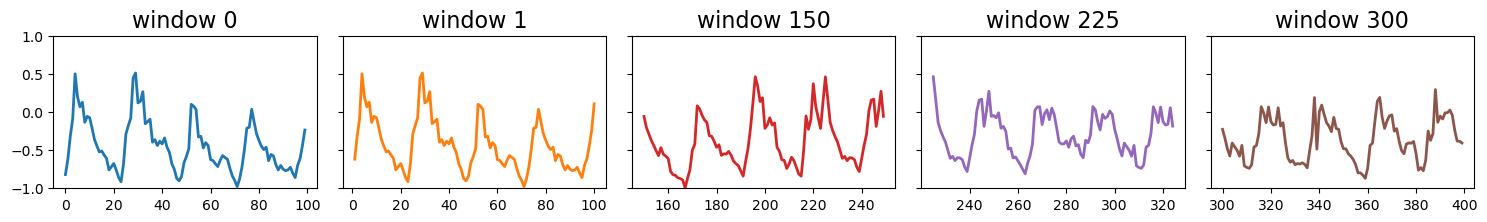

In [12]:
#plot windows
plot_rws(X)

## Training TadGAN 

In [13]:
from model import hyperparameters
from tadgan import TadGAN

In [14]:
hyperparameters["epochs"] = 35
hyperparameters["input_shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

In [15]:
tgan = TadGAN(**hyperparameters)
tgan.fit(X)

Epoch: 1/35, Losses: {'cx_loss': 2.831, 'cz_loss': 1.595, 'eg_loss': 0.8223}
Epoch: 2/35, Losses: {'cx_loss': -1.429, 'cz_loss': 1.4536, 'eg_loss': -2.0664}
Epoch: 3/35, Losses: {'cx_loss': -1.4444, 'cz_loss': 1.1824, 'eg_loss': -2.2427}
Epoch: 4/35, Losses: {'cx_loss': -1.3712, 'cz_loss': -3.0016, 'eg_loss': 2.6275}
Epoch: 5/35, Losses: {'cx_loss': -1.874, 'cz_loss': -5.2898, 'eg_loss': 4.5398}
Epoch: 6/35, Losses: {'cx_loss': -1.8312, 'cz_loss': -4.5818, 'eg_loss': 3.8665}
Epoch: 7/35, Losses: {'cx_loss': -1.7566, 'cz_loss': -3.4118, 'eg_loss': 1.6696}
Epoch: 8/35, Losses: {'cx_loss': -1.653, 'cz_loss': -2.5839, 'eg_loss': -0.0435}
Epoch: 9/35, Losses: {'cx_loss': -1.5157, 'cz_loss': -2.2597, 'eg_loss': -1.2492}
Epoch: 10/35, Losses: {'cx_loss': -1.3902, 'cz_loss': -2.2796, 'eg_loss': -2.5012}
Epoch: 11/35, Losses: {'cx_loss': -1.5201, 'cz_loss': -2.4813, 'eg_loss': -4.3409}
Epoch: 12/35, Losses: {'cx_loss': -1.4607, 'cz_loss': -2.8689, 'eg_loss': -4.682}
Epoch: 13/35, Losses: {'cx_l

## Testing

Using the fitted TadGAN model to reconstruct the time series signal. Then, utilize a combination of the reconstructed error and critic error to define anomaly regions.

Afterward, employ statistical metrics to evaluate the performance of TadGAN.

49/49 [==============================] - 1s 9ms/step


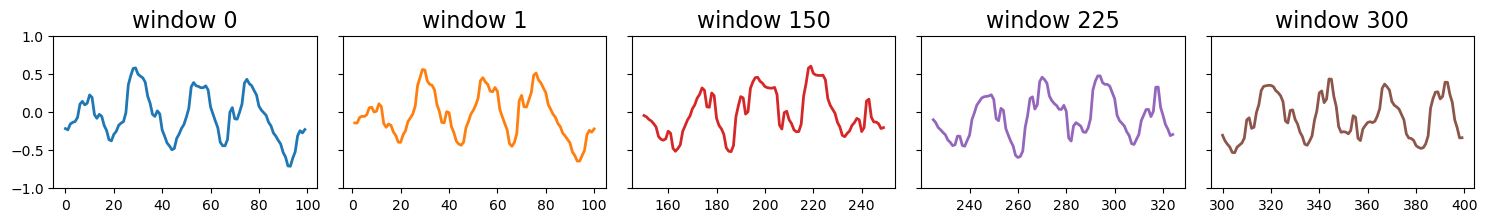

In [16]:
#reconstruct
X_hat, critic = tgan.predict(X)

#visualise X_hat
plot_rws(X_hat)

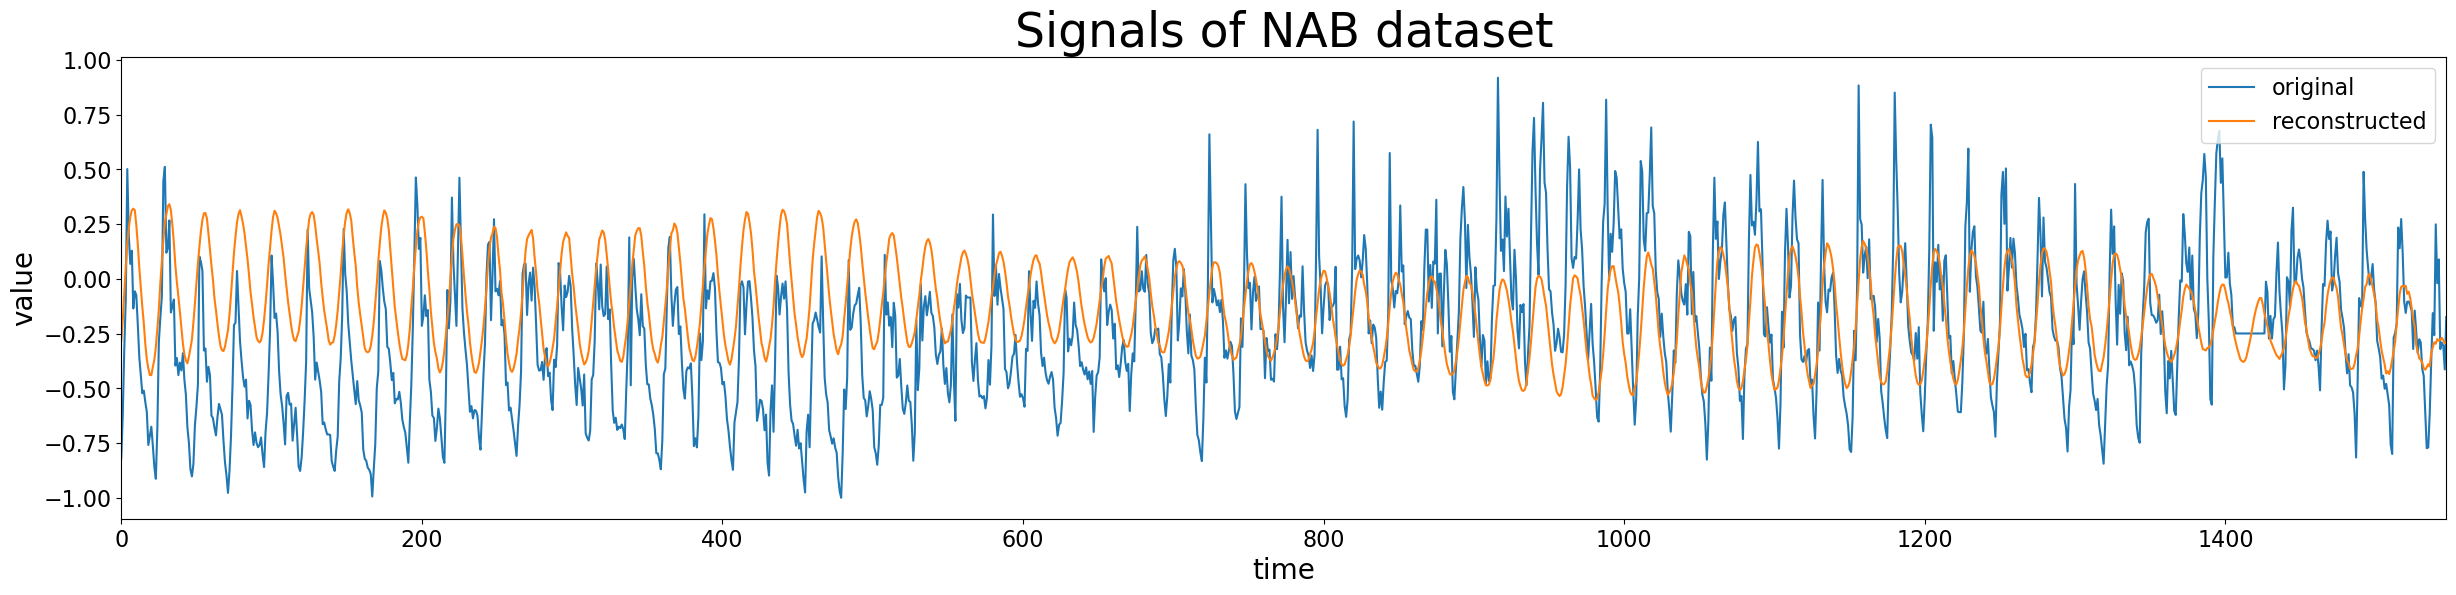

In [17]:
#flatten the predicted windows
y_hat = unroll_ts(X_hat)

#plot the time series
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

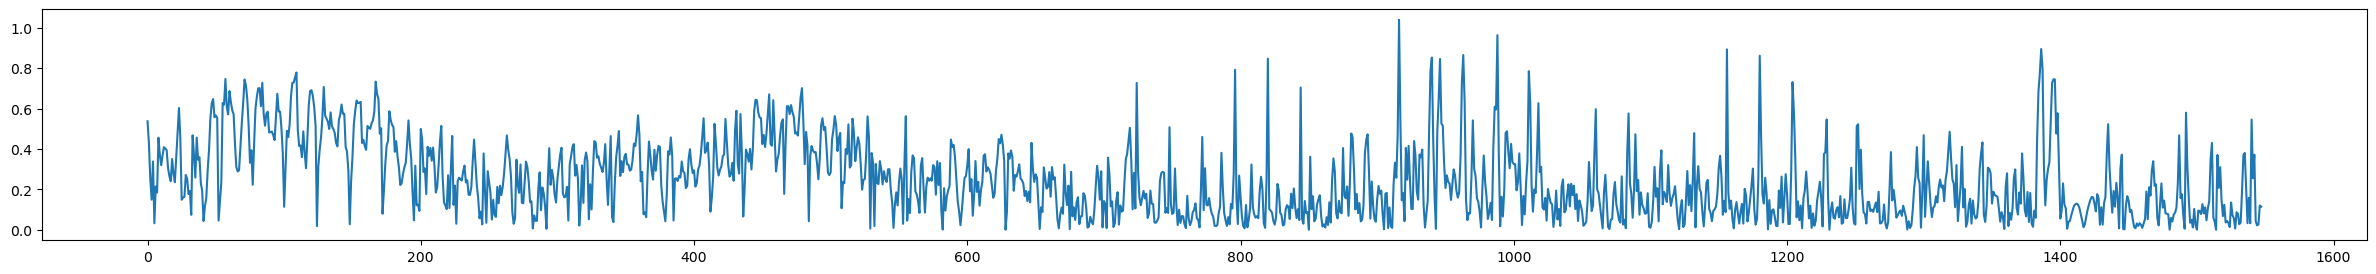

In [18]:
#pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

#visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()

Detect anomalies and calculate statistical metrics, including accuracy, precision, recall, and F1-Score.

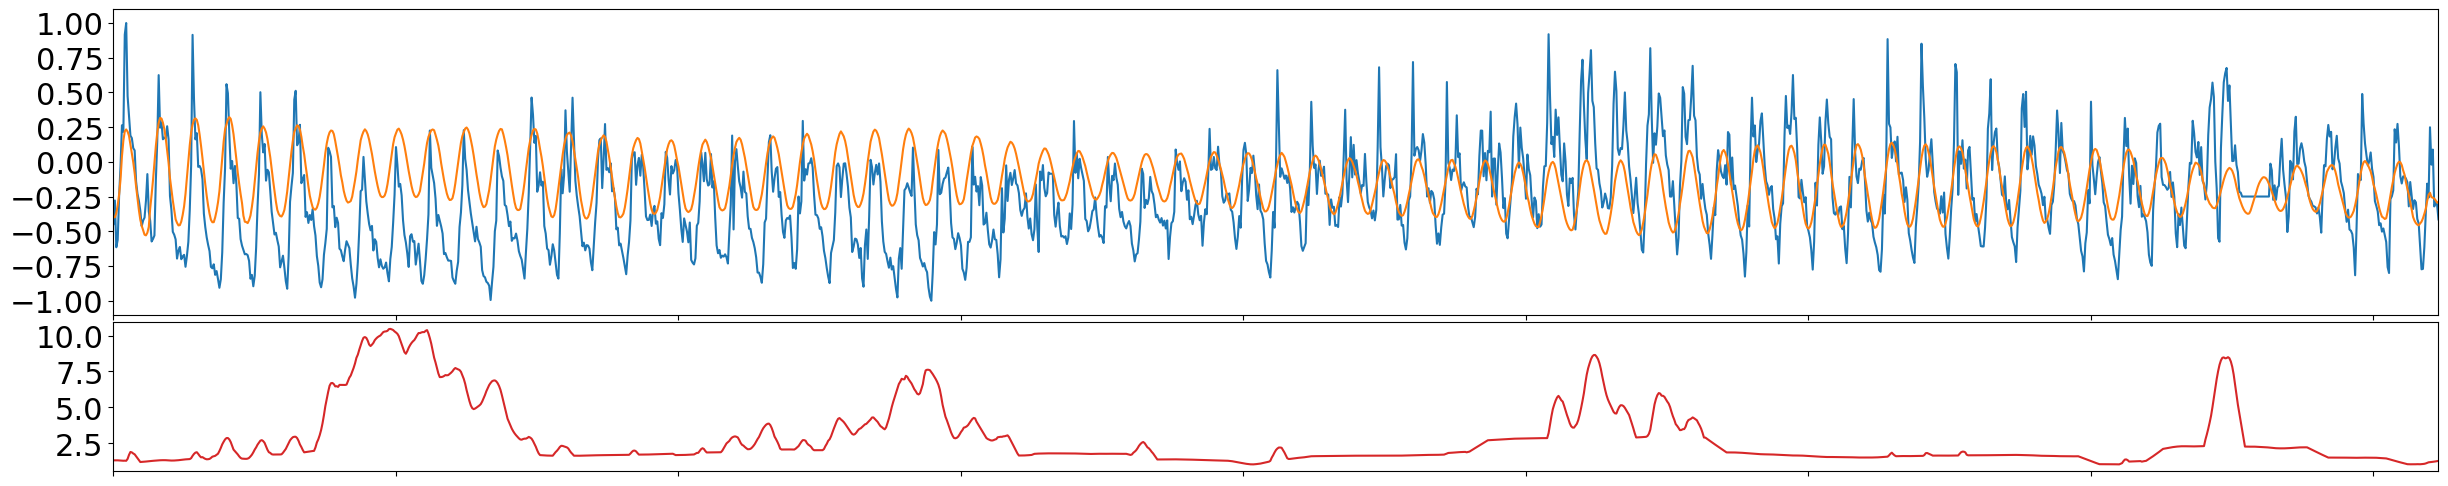

In [19]:
from tadgan import score_anomalies

error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)

# visualize the error curve
plot_error([[true, pred], error])

Utilise a predefined threshold, similar to TAnoGAN, for anomaly detection.

In [20]:
#set threshold
thresh = 10
#thresh = 8 

#anomaly intervals
intervals = list()

i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index[i]
    while i < len(error) and error[i] > thresh:
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals

[(1310151601, 1310198401, 10.252365296185273),
 (1310245201, 1310277601, 10.170417858524981)]

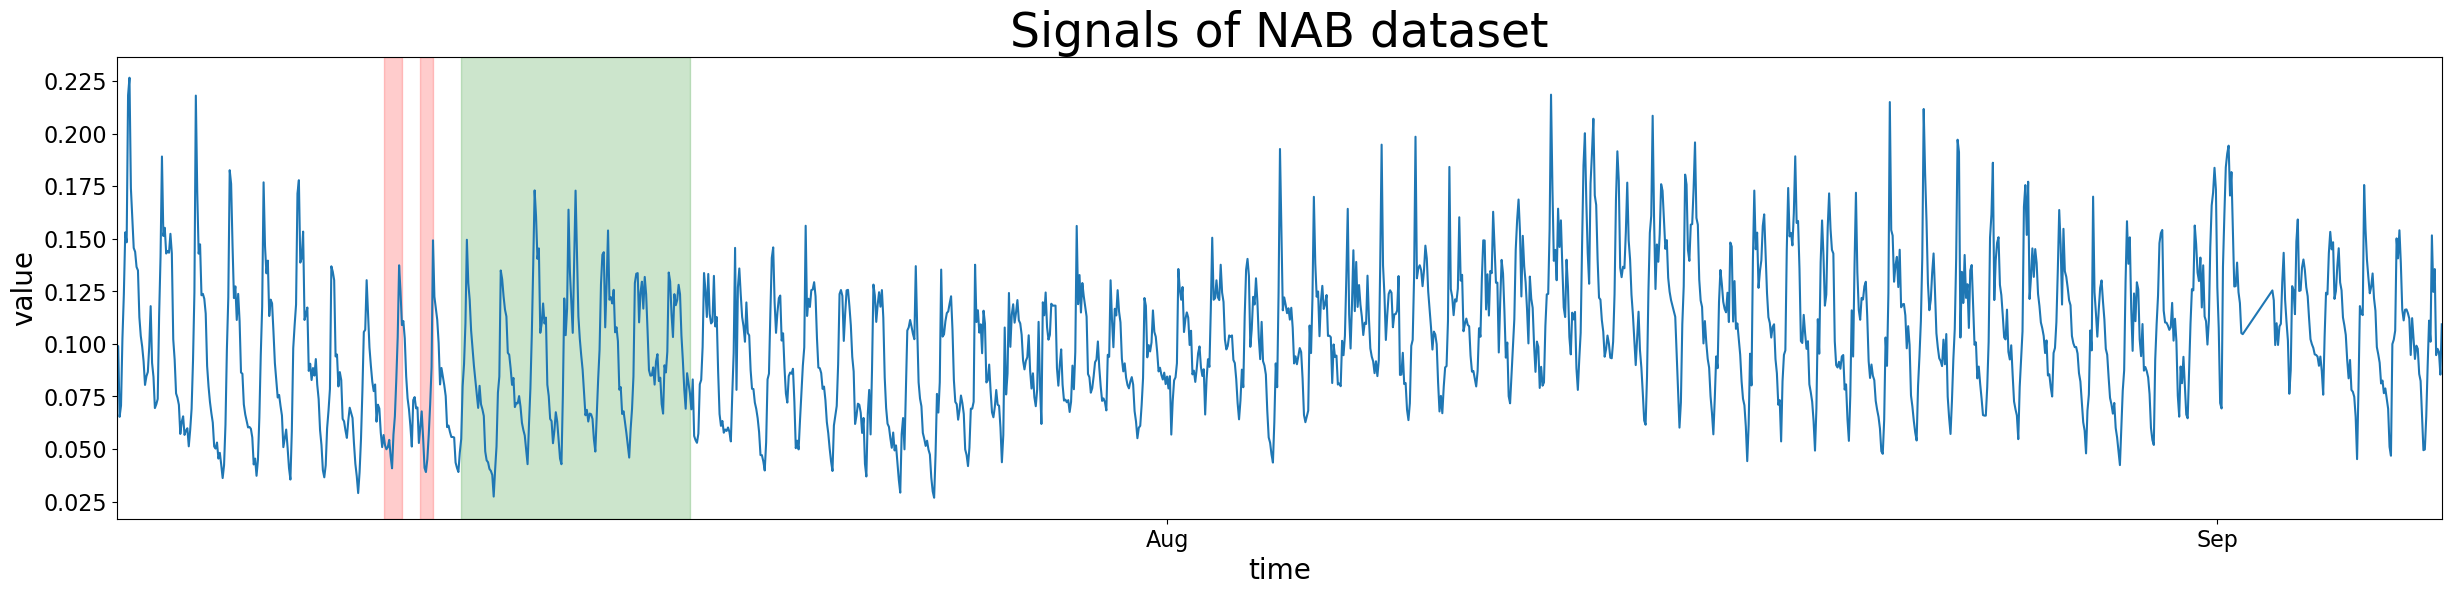

In [21]:
#plot signal, existing and detected anomalies
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])

In [22]:
from contextual import contextual_accuracy, contextual_f1_score, contextual_precision, contextual_recall

accuracy = contextual_accuracy(known_anomalies, anomalies, start=start, end=end)
precision = contextual_precision(known_anomalies, anomalies, start=start, end=end)
recall = contextual_recall(known_anomalies, anomalies, start=start, end=end)
f1_score = contextual_f1_score(known_anomalies, anomalies, start=start, end=end)

print("Accuracy score = {:0.3f}".format(accuracy))
print("Precision score = {:0.3f}".format(precision))
print("Recall score = {:0.3f}".format(recall))
print("F1 score = {:0.3f}".format(f1_score))

Accuracy score = 0.874
Precision score = 0.000
Recall score = 0.000
F1 score = nan


c:\Users\AnastasiaSinitsyna\Desktop\GIT\TadGAN\common.py:75: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall) / (precision + recall)


Employ an adopted windows method to identify anomaly regions as provided in TadGAN paper.

In [23]:
from timeseries_anomalies import find_anomalies

#detect anomaly regions
intervals = find_anomalies(error, index, 
                           window_size_portion=0.33,
                           window_step_size_portion=0.1, 
                           fixed_threshold=True)
intervals

array([[1.31305680e+09, 1.31343480e+09, 1.05247870e-01],
       [1.31465160e+09, 1.31505480e+09, 5.35383642e-01]])

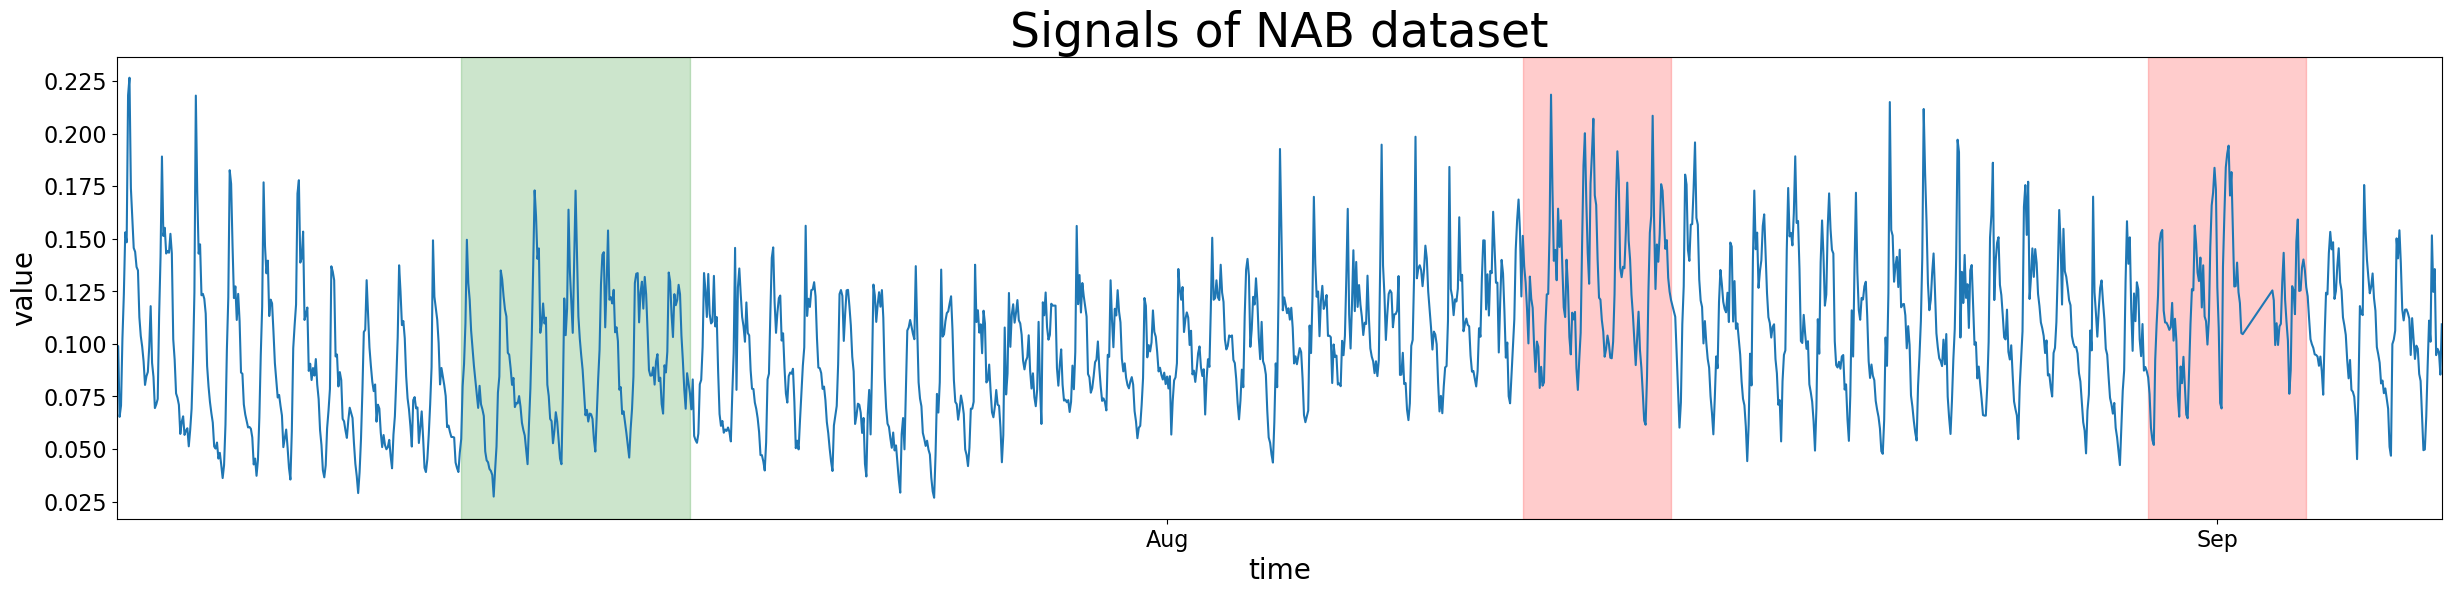

In [24]:
#plot signal, existig anomalies and detected anomalies
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])

In [25]:
anomalies

,start,end,score
0,1.313057e+09,1.313435e+09,0.105248
1,1.314652e+09,1.315055e+09,0.535384


In [26]:
from contextual import contextual_accuracy, contextual_f1_score, contextual_precision, contextual_recall

accuracy = contextual_accuracy(known_anomalies, anomalies, start=start, end=end)
precision = contextual_precision(known_anomalies, anomalies, start=start, end=end)
recall = contextual_recall(known_anomalies, anomalies, start=start, end=end)
f1_score = contextual_f1_score(known_anomalies, anomalies, start=start, end=end)

print("Accuracy score = {:0.3f}".format(accuracy))
print("Precision score = {:0.3f}".format(precision))
print("Recall score = {:0.3f}".format(recall))
print("F1 score = {:0.3f}".format(f1_score))


Accuracy score = 0.730
Precision score = 0.000
Recall score = 0.000
F1 score = nan


c:\Users\AnastasiaSinitsyna\Desktop\GIT\TadGAN\common.py:75: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall) / (precision + recall)
